# 猫狗大战毕业项目

数据集
[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)

### 1. 数据预处理
#### 1.1 利用keras的`ImageDataGenerator` 函数进行统一的预处理，生成批次的带实时数据增益的张量图像数据, `ImageDataGenerator` 需要将不同类别的图片分类后放置到相同的目录内；这里准备使用创建文件软链接的方式来分类文件

In [1]:
from tqdm import tqdm      # a nice pretty percentage bar for tasks.
import os
import shutil
import numpy as np
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint
import pandas as pd
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
# from pprint import pprint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import h5py
import matplotlib.pyplot as plt
import random
import cv2

CUR_PATH = os.getcwd()
ORG_TRAIN_DIR = CUR_PATH +'/all/train/'
ORG_TEST_DIR = CUR_PATH + '/all/test/'
TRAIN_DIR = CUR_PATH + "/input/train"
TRAIN_CAT_DIR = TRAIN_DIR + "/cat/"
TRAIN_DOG_DIR = TRAIN_DIR + "/dog/"
TEST_DIR = CUR_PATH + "/input/test"
H5PY_PATH = CUR_PATH + "/saved_models/"

Using TensorFlow backend.


In [2]:
def sort_img(dir_path):
    '''判断图片是猫还是狗'''
    train_filenames = os.listdir(dir_path)
#     print(train_filenames)
    train_cat = list(filter(lambda x:x.split('.')[0] == 'cat', train_filenames))
    train_dog = list(filter(lambda x:x.split('.')[0] == 'dog', train_filenames))
    return train_cat , train_dog

def create_dir(dir_path):
    '''建立指定的目录'''
    remove_dir(dir_path)
    cmd = "mkdir -p " + dir_path
    os.system(cmd)

def remove_dir(dir_path):
    cmd = "rm -rf " + dir_path
    os.system(cmd)
    print(cmd)

def create_symlink(ori_path,tar_apth):
    cmd = "ln -s " + ori_path + ' ' + tar_apth
    os.system(cmd)

def process_train_data(data_list, org_path, tar_path):
    '''建立分猫狗分类目录及软链接'''
    create_dir(tar_path)
    for img in tqdm(data_list):
        create_symlink(org_path + img,tar_path + img)
        
def read_path_data(dir_path):
    '''读取指定目录数据到内存'''
    files = os.listdir(dir_path)
    full_path_data = []
    for item in files:
        full_path_data.append(dir_path+item)
    
    return full_path_data

In [3]:
cat, dog = sort_img(ORG_TRAIN_DIR) #分别建立猫狗数据
train_data = read_path_data(ORG_TRAIN_DIR) #读取原训练集数据

In [4]:
process_train_data(cat,ORG_TRAIN_DIR,TRAIN_CAT_DIR) 
process_train_data(dog,ORG_TRAIN_DIR,TRAIN_DOG_DIR)

create_dir(TEST_DIR)
create_symlink(ORG_TEST_DIR,TEST_DIR)

100%|██████████| 12500/12500 [01:03<00:00, 196.39it/s]


#### 1.2 数据探索

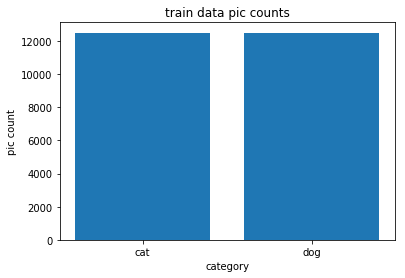

In [5]:
x =np.array([len(cat),len(dog)])
plt.bar(['cat','dog'],[x[0],x[1]])
plt.xlabel('category')
plt.ylabel('pic count')
plt.title('train data pic counts')
plt.show()

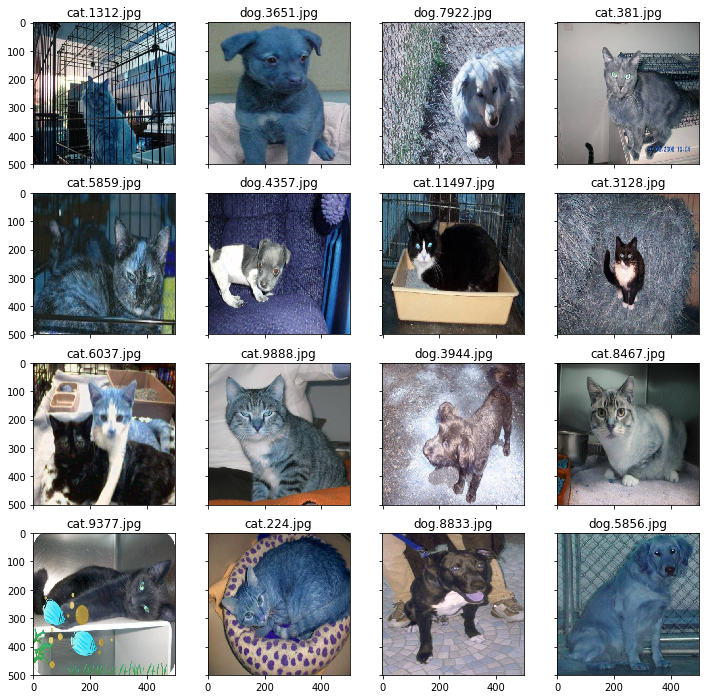

In [6]:
random.seed(2018)
#查看图片内容
fig,ax = plt.subplots(4,4,sharex='col',sharey='row',figsize=(12,12))
train_filenames = os.listdir(ORG_TRAIN_DIR)
#随机获取图片
for i in range(4):
    for j in range(4):
        ran = random.randint(0,len(train_filenames))
        img = cv2.imread(ORG_TRAIN_DIR + train_filenames[ran])
        img = cv2.resize(img, (500,500))
        ax[i,j].set_title('%s'% train_filenames[ran])
        ax[i,j].imshow(img)

打印出图片散点分布图

In [68]:
def get_data_shape(files):
    '''取到数据的尺寸'''
    shape_list = []
    for item in files:
        img = cv2.imread(item)
        shape_list.append([img.shape[0],img.shape[1]])
    return (shape_list)


shape_list = get_data_shape(train_data)

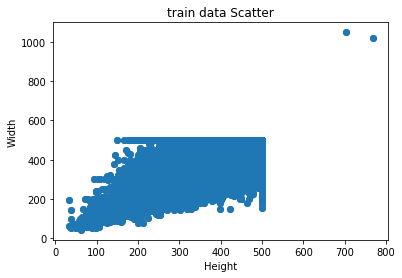

In [69]:
x_index = [i[0] for i in shape_list]
y_index = [i[1] for i in shape_list]

plt.title('train data Scatter')
plt.scatter(x_index,y_index)
plt.xlabel('Height')
plt.ylabel('Width')
plt.plot(x_index,y_index,'o')
plt.show()

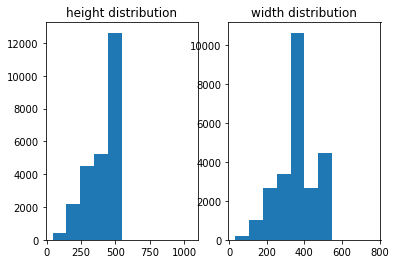

训练集: 
median of height: 447.0
median of width: 374.0


In [70]:
plt.title("train data Histogram")
plt.subplot(121)
plt.hist(y_index)
plt.title("height distribution")

plt.subplot(122)
plt.hist(x_index)
plt.title("width distribution")

plt.show()

print('训练集: ')
print('median of height: {}'.format(np.median(y_index)))
print('median of width: {}'.format(np.median(x_index)))

In [74]:
test_data = read_path_data(ORG_TEST_DIR)
test_shape_list = get_data_shape(test_data)
x_index = [i[0] for i in test_shape_list]
y_index = [i[1] for i in test_shape_list]

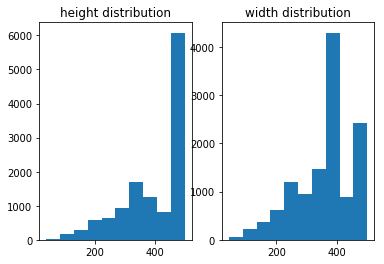

测试集: 
median of height: 447.0
median of width: 374.0


In [75]:
plt.title("test data Histogram")
plt.subplot(121)
plt.hist(y_index)
plt.title("height distribution")

plt.subplot(122)
plt.hist(x_index)
plt.title("width distribution")

plt.show()

print('测试集: ')
print('median of height: {}'.format(np.median(y_index)))
print('median of width: {}'.format(np.median(x_index)))

#### 1.3 采用预处理模型剔除异常数据

In [83]:
image_net_classes = CUR_PATH + '/ImageNet_animal_Classes.csv'
img_size = (299, 299) 
## 载入预先下载好的ImageNet分类csv文件
import csv

def get_imageNet_class(file_path):
    data_list = []
    with open(file_path,'r') as f:
        data_list = list(csv.reader(f))
    
    return list(n[0] for n in data_list if n[1] in ['猫','狗'])

def preprocess_image(img_path, model_preprocess):
    img = image.load_img(img_path,target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = model_preprocess(x) #归一化
    
    return (x)

def preprocess_image_dir(dir_list,model_preprocess):
    
    return [preprocess_image(fp, model_preprocess) for fp in tqdm(dir_list)]

imageNet_class = get_imageNet_class(image_net_classes)
# preprocess_imgs = preprocess_image_dir(train_data[:5000],xception.preprocess_input)
preprocess_imgs = preprocess_image_dir(train_data,xception.preprocess_input)

100%|██████████| 25000/25000 [02:35<00:00, 161.01it/s]


In [84]:
def predict_model(model,imgs,model_decode,top = 10):
    pred = model.predict(imgs)
    return model_decode(pred,top=top)[0]

def get_predict(model,imgs,model_decode, top=10):
    return [ predict_model(model, x,model_decode, top) for x in tqdm(imgs) ]
        
model= Xception(weights='imagenet')

##预测模型,反复深度top调整为50可以较好的包含猫狗图片
pred = get_predict(model, preprocess_imgs,xception.decode_predictions, 50 )

100%|██████████| 25000/25000 [03:22<00:00, 123.34it/s]


<class 'list'>


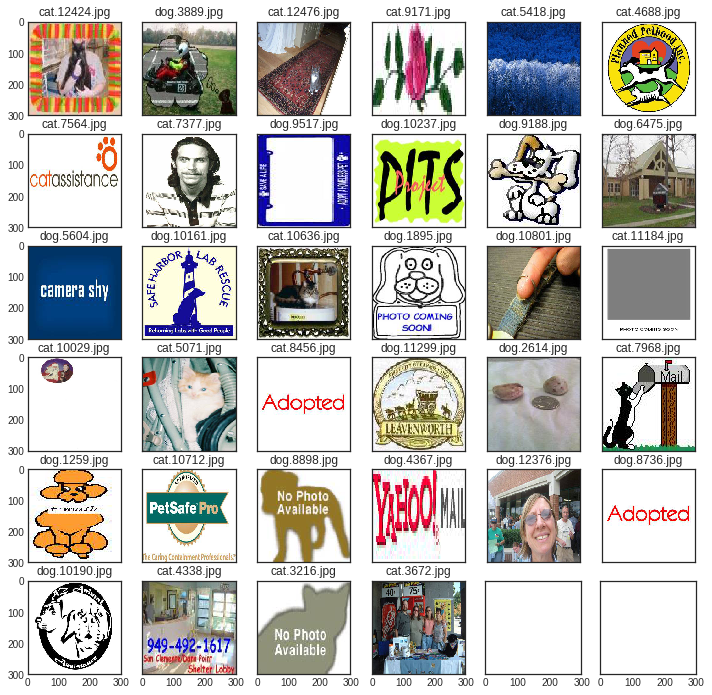

In [92]:
import math
# 获取能识别为猫狗类型的预测总数
def get_result_list(pred):
    print(type(pred))
    result = []
    for index, item in enumerate(pred):
        result.insert(index,0);
        for value in item:
            if value[0] in imageNet_class:
                result[index] = 1
                break;
    return result

#标记了所有数据 1为猫狗，0为其它
right_list = get_result_list(pred)
exp_list = []
for index, value in enumerate(right_list):
    if value == 0:
        exp_list.append(train_data[index])
        
plt.style.use('seaborn-white')

#查看图片内容
def_row,def_col = 6,6
fig, ax = plt.subplots(def_row, def_col, sharex='col',sharey='row',figsize=(12,12))

#计算行
total = len(exp_list)
# print('total %s' %total)
row = math.ceil(total / def_col) 
#计算列
col = def_col  if row > 0 else  total

for i in range(row):
    count = i * col
#     print('row %s' %i)
    for j in range(col):
#         print(count+j)
        img = image.load_img(exp_list[count+j],target_size=img_size)
        ax[i,j].set_title(exp_list[count+j].split("/")[-1])
        ax[i,j].imshow(img)
        if count+j == total-1:
            break

1. 从上图中通过预训练模型对图片筛选出异常的图片，再结合人工筛选进一步筛选图片，保留正确的cat.10712.jpg
2. 同时添加，人工剔除图片cat.4085.jpg,dog.1773.jpg

In [114]:
manual_right_list = ['cat.10712.jpg']
manual_exp_list = ['cat.4085.jpg','dog.1773.jpg',]
for i in manual_exp_list:
    exp_list.append('%s/%s'%(CUR_PATH,i))
for item in range(len(exp_list) - 1, -1, -1):
    if exp_list[item].split("/")[-1] in manual_right_list:
        del exp_list[item]
print(len(exp_list))

37


In [123]:
# 剔除异常数据
for i in exp_list :
    file_name = i.split("/")[-1]
    category = file_name.split('.')[0]
    full_path = "rm -rf %s/%s/%s" %(TRAIN_DIR,category,file_name)
#     print(full_path)
    os.system(full_path)
#     remove_dir(full_path)

rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/cat/cat.12424.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/dog/dog.3889.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/cat/cat.12476.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/cat/cat.9171.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/cat/cat.5418.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/cat/cat.4688.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/cat/cat.7564.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/cat/cat.7377.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/dog/dog.9517.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/dog/dog.10237.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/dog/dog.9188.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/dog/dog.6475.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/dog/dog.5604.jpg
rm -rf /home/ubuntu/capstone/dog_vs_cat/input/train/dog/dog.10161.jpg
rm -rf /home/ubuntu/capstone/d

In [111]:
import subprocess
##显示保留数据
# cmd = "ls %s | wc -l" %(TRAIN_CAT_DIR)
# cmd = "ls %s | wc -l" %(TRAIN_DOG_DIR)

### 2 导出特征向量

keras的提供了可选的模型

模型|	大小|	Top-1 准确率	|Top-5准确率|	参数数量|	深度
----|---|---|---|---|---
Xception	|88 MB	|0.790	|0.945|	22,910,480	|126
VGG16	|528 MB	|0.715	|0.901	|138,357,544	|23
VGG19	|549 MB	|0.727|	0.910	|143,667,240	|26
ResNet50|	99 MB	|0.759	|0.929	|25,636,712|168
InceptionV3	|92 MB|	0.788|	0.944	|23,851,784|	159
InceptionResNetV2|	215 MB	|0.804	|0.953	|55,873,736|	572
MobileNet	|17 MB|	0.665|	0.871|	4,253,864	|88
DenseNet121	|33 MB	|0.745|	0.918	|8,062,504	|121
DenseNet169	|57 MB|	0.759	|0.928|	14,307,880	|169
DenseNet201	|80 MB|	0.770|	0.933	|20,242,984	|201

这里只使用 InceptionV3 和 Xception 这两个模型。

In [124]:
def write_gap(MODEL, image_size, lambda_func=None):
   
    h5_full_path =  H5PY_PATH + MODEL.__name__ + '.h5'
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(TRAIN_DIR, image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory(TEST_DIR, image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    model.summary()
#     pprint(MODEL.__name__)
#     return

    train = model.predict_generator(train_generator)
    test = model.predict_generator(test_generator)
    remove_dir(h5_full_path)
    
    with h5py.File(h5_full_path) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

In [ ]:
# write_gap(ResNet50, (224, 224))
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
write_gap(Xception, (299, 299), xception.preprocess_input)

In [80]:
#  定义导入特征向量函数
def load_eigenvector(path_list=[]):
    x_train = []
    x_test = []
    for file_path in path_list:
        with h5py.File(file_path, 'r') as fp:
            x_train.append(np.array(fp['train']))
            x_test.append(np.array(fp['test']))
            y_train = np.array(fp['label'])

    x_train = np.concatenate(x_train, axis=1)
    x_test = np.concatenate(x_test, axis=1)
    x_train, y_train = shuffle(x_train, y_train)
    return x_train, y_train, x_test

# 增加全连接层
def full_connect_layer(x_train, dropout_rate = 0.2):
    input_tensor = Input(x_train.shape[1:])
    model = Model(input_tensor, Dropout(dropout_rate)(input_tensor))
    model = Model(model.input, Dense(1, activation = 'sigmoid')(model.output))
    # 编译模型
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# 训练函数
def model_fit(model,x_train,y_train,chk_point_file,epochs = 10,batch_size = 128):
    remove_dir(chk_point_file)
    history_train = model.fit(x_train, y_train, validation_split = 0.2,epochs = epochs, 
                              batch_size = batch_size, verbose=1,
                              callbacks=[ModelCheckpoint(filepath=chk_point_file, verbose=1, save_best_only=True)])
    return history_train

# 定义打印训练历史
def plt_history(data) :
    plt.plot(data.history['val_loss'])
    plt.xlabel('time')
    plt.ylabel('val_loss')
    plt.show()
    
    plt.plot(data.history['val_acc'])
    plt.xlabel('times')
    plt.ylabel('val_acc')
    plt.show()

def save_pred(y_pred,save_name):
    '''预测测试集'''
    df = pd.read_csv("sample_submission.csv")

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory(TEST_DIR, (299, 299), shuffle=False, 
                                             batch_size=128, class_mode=None)

    for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
        df.at[index-1, 'label'] = y_pred[i]

    df.to_csv(save_name, index=None)
#     df.head(10)
    return df

### 尝试1. 导入保存的权重InceptionV3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 2048)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


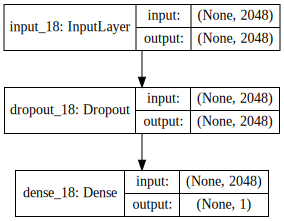

In [81]:
file_name = H5PY_PATH + "InceptionV3.h5"
x_train, y_train,x_test = load_eigenvector([file_name])
inception_v3_model = full_connect_layer(x_train)

SVG(model_to_dot(inception_v3_model, show_shapes=True).create(prog='dot', format='svg'))

In [82]:
# 训练
chk_point_file = H5PY_PATH +'InceptionV3.best.h5'
history_train = model_fit(inception_v3_model,x_train,y_train,chk_point_file,epochs=6)

rm -rf /home/ubuntu/capstone/dog_vs_cat/saved_models/InceptionV3.best.h5
Train on 19972 samples, validate on 4993 samples
Epoch 1/6
19972/19972 [==============================] - 1s 51us/step - loss: 0.1186 - acc: 0.9697 - val_loss: 0.0372 - val_acc: 0.9932

Epoch 00001: val_loss improved from inf to 0.03720, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/InceptionV3.best.h5
Epoch 2/6
19972/19972 [==============================] - 0s 24us/step - loss: 0.0332 - acc: 0.9917 - val_loss: 0.0247 - val_acc: 0.9950

Epoch 00002: val_loss improved from 0.03720 to 0.02474, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/InceptionV3.best.h5
Epoch 3/6
19972/19972 [==============================] - 0s 24us/step - loss: 0.0253 - acc: 0.9932 - val_loss: 0.0211 - val_acc: 0.9956

Epoch 00003: val_loss improved from 0.02474 to 0.02107, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/InceptionV3.best.h5
Epoch 4/6
19972/19972 [==============================] - 

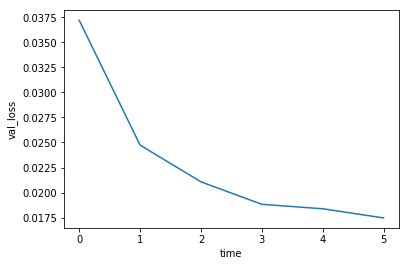

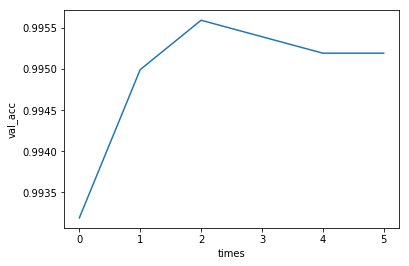

In [83]:
plt_history(history_train)

In [84]:
y_pred = inception_v3_model.predict(x_test) #inceptionV3模型
y_pred = y_pred.clip(min = 0.005, max = 0.995)
df = save_pred(y_pred,"IncV3.csv")
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.994998
1,2,0.995000
2,3,0.995000
3,4,0.995000
4,5,0.005000
5,6,0.005000
6,7,0.005000
7,8,0.005000
8,9,0.005000
9,10,0.005000


### 尝试2. 导入Xception模型权重

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 2048)              0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


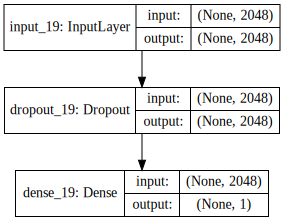

In [85]:
file_name = H5PY_PATH + "Xception.h5"
x_train, y_train,x_test = load_eigenvector([file_name])
Xception = full_connect_layer(x_train)

SVG(model_to_dot(Xception, show_shapes=True).create(prog='dot', format='svg'))

In [86]:
chk_point_file = H5PY_PATH +'Xception.best.h5'
history_train_1 = model_fit(Xception,x_train,y_train,chk_point_file,epochs=8)

rm -rf /home/ubuntu/capstone/dog_vs_cat/saved_models/Xception.best.h5
Train on 19972 samples, validate on 4993 samples
Epoch 1/8
19972/19972 [==============================] - 1s 52us/step - loss: 0.1366 - acc: 0.9766 - val_loss: 0.0425 - val_acc: 0.9940

Epoch 00001: val_loss improved from inf to 0.04250, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/Xception.best.h5
Epoch 2/8
19972/19972 [==============================] - 0s 25us/step - loss: 0.0367 - acc: 0.9925 - val_loss: 0.0275 - val_acc: 0.9946

Epoch 00002: val_loss improved from 0.04250 to 0.02754, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/Xception.best.h5
Epoch 3/8
19972/19972 [==============================] - 0s 25us/step - loss: 0.0269 - acc: 0.9934 - val_loss: 0.0229 - val_acc: 0.9946

Epoch 00003: val_loss improved from 0.02754 to 0.02285, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/Xception.best.h5
Epoch 4/8
19972/19972 [==============================] - 0s 24us/step

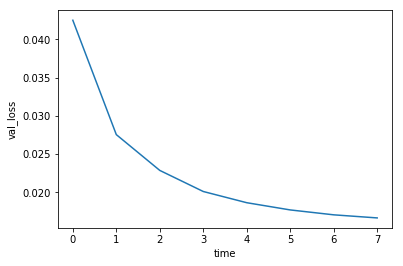

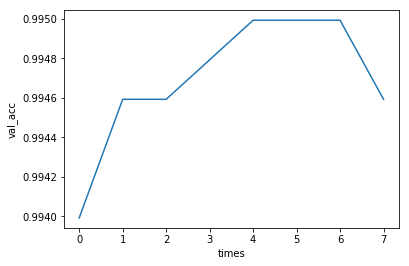

In [87]:
plt_history(history_train_1)

In [88]:
y_pred = Xception.predict(x_test) #Xception
y_pred = y_pred.clip(min = 0.005, max = 0.995)
df = save_pred(y_pred,"Xception.csv")
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


### 尝试3. 导入混合模型权重

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 4096)              0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 4097      
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


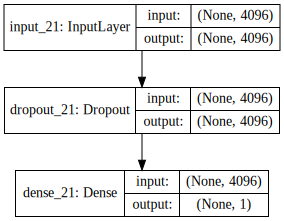

In [93]:
file_list = [H5PY_PATH + "Xception.h5", H5PY_PATH + "InceptionV3.h5"]
x_train, y_train, x_test = load_eigenvector(file_list)
Xception_IncV3 = full_connect_layer(x_train,dropout_rate=0.3)

SVG(model_to_dot(Xception_IncV3, show_shapes=True).create(prog='dot', format='svg'))

In [94]:
chk_point_file = H5PY_PATH +'Xception_IncV3.best.h5'
history_train_3 = model_fit(Xception_IncV3,x_train,y_train,chk_point_file,epochs=8)

rm -rf /home/ubuntu/capstone/dog_vs_cat/saved_models/Xception_IncV3.best.h5
Train on 19972 samples, validate on 4993 samples
Epoch 1/8
19972/19972 [==============================] - 1s 58us/step - loss: 0.0796 - acc: 0.9796 - val_loss: 0.0225 - val_acc: 0.9952

Epoch 00001: val_loss improved from inf to 0.02245, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/Xception_IncV3.best.h5
Epoch 2/8
19972/19972 [==============================] - 1s 27us/step - loss: 0.0226 - acc: 0.9945 - val_loss: 0.0157 - val_acc: 0.9954

Epoch 00002: val_loss improved from 0.02245 to 0.01571, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/Xception_IncV3.best.h5
Epoch 3/8
19972/19972 [==============================] - 1s 27us/step - loss: 0.0173 - acc: 0.9950 - val_loss: 0.0134 - val_acc: 0.9954

Epoch 00003: val_loss improved from 0.01571 to 0.01345, saving model to /home/ubuntu/capstone/dog_vs_cat/saved_models/Xception_IncV3.best.h5
Epoch 4/8
19972/19972 [======================

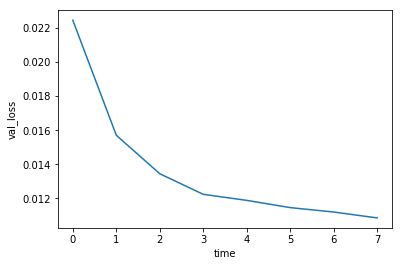

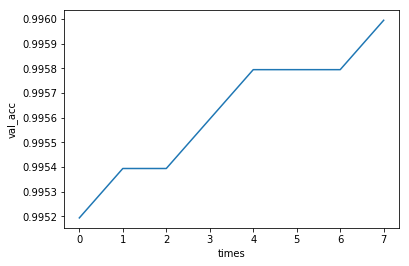

In [95]:
plt_history(history_train_3)

In [96]:
y_pred = Xception_IncV3.predict(x_test) # 混合模型特征
y_pred = y_pred.clip(min = 0.005, max = 0.995)
df = save_pred(y_pred,"Xception_IncV3.csv")
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


### 尝试不同的dropout保留率
尝试范围0.1-0.9

In [22]:
epochs = 10
dropout_result= []
for rate in np.arange(0.1, 1.0, 0.1):
    model =  full_connect_layer(x_train, dropout_rate=rate)
    train_result = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2)
    dropout_result.append((rate,train_result.history['val_loss'],train_result.history['val_acc']))
#     print(dropout_result)
#     break

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4097      
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________
Train on 19972 samples, validate on 4993 samples
Epoch 1/10
19972/19972 [==============================] - 1s 41us/step - loss: 0.0719 - acc: 0.9818 - val_loss: 0.0187 - val_acc: 0.9966
Epoch 2/10
19972/19972 [==============================] - 1s 27us/step - loss: 0.0200 - acc: 0.9948 - val_loss: 0.0132 - val_acc: 0.9966
Epoch 3/10
19972/19972 [==============================] - 1s 27us/step - loss: 0.

19972/19972 [==============================] - 1s 27us/step - loss: 0.0116 - acc: 0.9959 - val_loss: 0.0099 - val_acc: 0.9968
Epoch 9/10
19972/19972 [==============================] - 1s 27us/step - loss: 0.0115 - acc: 0.9961 - val_loss: 0.0096 - val_acc: 0.9972
Epoch 10/10
19972/19972 [==============================] - 1s 27us/step - loss: 0.0100 - acc: 0.9967 - val_loss: 0.0100 - val_acc: 0.9966
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 4097      
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________
Tra

19972/19972 [==============================] - 1s 27us/step - loss: 0.0246 - acc: 0.9927 - val_loss: 0.0102 - val_acc: 0.9964
Epoch 6/10
19972/19972 [==============================] - 1s 27us/step - loss: 0.0208 - acc: 0.9941 - val_loss: 0.0103 - val_acc: 0.9972
Epoch 7/10
19972/19972 [==============================] - 1s 27us/step - loss: 0.0205 - acc: 0.9933 - val_loss: 0.0107 - val_acc: 0.9972
Epoch 8/10
19972/19972 [==============================] - 1s 27us/step - loss: 0.0191 - acc: 0.9943 - val_loss: 0.0122 - val_acc: 0.9958
Epoch 9/10
19972/19972 [==============================] - 1s 27us/step - loss: 0.0205 - acc: 0.9941 - val_loss: 0.0093 - val_acc: 0.9970
Epoch 10/10
19972/19972 [==============================] - 1s 27us/step - loss: 0.0228 - acc: 0.9932 - val_loss: 0.0092 - val_acc: 0.9966
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 4096)              0

In [23]:
## dropout rate and val_loss
pd_data = []
for index in range(len(dropout_result)):
    row = []
    num = dropout_result[index][1]
    row.append(np.average(num))
    row.append(np.max(num))
    row.append(np.min(num))
    pd_data.append(row)

val_loss_df = pd.DataFrame(
    data=pd_data,
    index=np.arange(0.1, 1.0, 0.1),
    columns=['Avg', 'Max', 'Min']
)
val_loss_df.index.name = 'dropout rate'
val_loss_df

,Avg,Max,Min
dropout rate,,,
0.1,0.011573,0.018656,0.009499
0.2,0.011771,0.022689,0.009578
0.3,0.011601,0.019709,0.009428
0.4,0.011469,0.019021,0.009629
0.5,0.012075,0.022814,0.009450
0.6,0.011499,0.020943,0.009068
0.7,0.011637,0.022168,0.008822
0.8,0.012162,0.021450,0.009163
0.9,0.013119,0.024177,0.009788


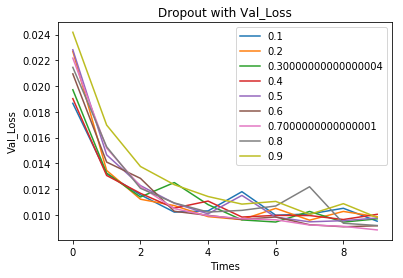

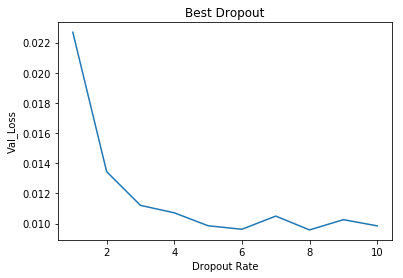

In [24]:
for index in range(len(dropout_result)):
    plt.plot(dropout_result[index][1],label=dropout_result[index][0])

plt.title('Dropout with Val_Loss')
plt.xlabel('Times')
plt.ylabel('Val_Loss')
plt.legend()
plt.show() 


## best dropout
plt.title('Best Dropout')
plt.plot(np.arange(1,11,1),[x for x in dropout_result[1][1]])
plt.xlabel('Dropout Rate')
plt.ylabel('Val_Loss')
plt.show()